## Classifying Movie Reviews
*A binary classification example*
### Loading the Dataset
Load the dataset and keep the 10.000 most frequently occurring words.
The loaded data is split 50/50 into train data and test data.

In [24]:
# for running on CPU only (Laptop)
import os
# (opt.) force CPU use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [1]:
from keras.datasets import imdb

# load data and split into training and test (50/50)
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## decode and display single entry of dataset
# get word -> index mapping from dataset
word_index = imdb.get_word_index()
# reverse to get index -> word mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# decode review
decoded_review = " ".join(reverse_word_index.get(i - 3, "?") for i in train_data[0])
#--- index offset because 0, 1, and 2 are reserved for "padding", "start of sequence" and "unknown"
print(decoded_review)

Using TensorFlow backend.


? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

### Prepare the Data
Only Tensors can be fed into a neural network, therefore two options:
1. pad lists to same length and turn into tensor of shape (samples, word_indices) e.g. for *Embedding Layer*
2. encode lists into vectors of size 10.000 e.g. for *Dense Layer*
    - index list of [3, 5] turns into vector with all 0 except for position 3 & 5

In [2]:
import numpy as np

# function to turn list of indices into vector with indices set to 1 (default 0)
def vectorize_sequences(sequences, dimension=10000):
    # create matrix of size: number of sequences (reviews) X dimension of sequence (10.000)
    results = np.zeros((len(sequences), dimension))
    # set indices of sequence to 1
    for i, seq in enumerate(sequences):
        results[i, seq] = 1
    return results

# vectorize training and test data
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# vectorize labels (already 1 = positive / 0 = negative)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building the Network
The network is proposed as:
+ 2 intermediate layers (Dense) with 16 hidden units & relu activations
+ 1 output layer (Dense) with 1 hidden unit & sigmoid activation

In [16]:
from keras import models, layers, optimizers, losses, metrics

# create sequential model to add layers
model = models.Sequential()
# add intermediate layers
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
# add output layer
model.add(layers.Dense(1, activation="sigmoid"))

# compiling model with rmsprop optimizer & binary_crossentropy loss function
model.compile(
    # configure optimizer
    optimizer=optimizers.RMSprop(lr=0.001),
    # configure loss function
    loss=losses.binary_crossentropy,
    # configure metrics
    metrics=[metrics.binary_accuracy]
)

### Validate & Train Model
Monitoring accuracy on never before seen images during training, by setting apart validation set from the training data (10.000 entries)

In [4]:
## Hold-out validation
# x_val = x_train[:10000]
# partial_x_train = x_train[10000:]
# y_val = y_train[:10000]
# partial_y_train = y_train[10000:]
# 
# ## train network
# history = model.fit(
#     partial_x_train,
#     partial_y_train,
#     # train samples for 20 iterations (epochs)
#     epochs=5,
#     # train in batches of 512
#     batch_size=512,
#     # provide validation data
#     validation_data=(x_val, y_val)
# )
# results = model.evaluate(x_test, y_test)
# print(results)

Instructions for updating:
Use tf.cast instead.
Train on 15000 samples, validate on 10000 samples
Epoch 1/5
15000/15000 [==============================] - 5s 358us/step - loss: 0.5084 - binary_accuracy: 0.7813 - val_loss: 0.3797 - val_binary_accuracy: 0.8684
Epoch 2/5
15000/15000 [==============================] - 2s 161us/step - loss: 0.3004 - binary_accuracy: 0.9047 - val_loss: 0.3004 - val_binary_accuracy: 0.8897
Epoch 3/5
15000/15000 [==============================] - 2s 161us/step - loss: 0.2179 - binary_accuracy: 0.9285 - val_loss: 0.3085 - val_binary_accuracy: 0.8711
Epoch 4/5
15000/15000 [==============================] - 2s 163us/step - loss: 0.1750 - binary_accuracy: 0.9437 - val_loss: 0.2840 - val_binary_accuracy: 0.8832
Epoch 5/5
25000/25000 [==============================] - 4s 151us/step
[0.3069652450990677, 0.87744]


In [22]:
## K-fold validation
k = 5
num_val_samples = len(x_train) // k
# shuffle data
idx = np.random.permutation(len(x_train))
x_train_shuffled, y_train_shuffled = x_train[idx], y_train[idx]

histories = {}

validation_scores = []
for fold in range(k):
    # segment validation data
    x_val = x_train_shuffled[num_val_samples * fold : num_val_samples * (fold+1)]
    y_val = y_train_shuffled[num_val_samples * fold : num_val_samples * (fold+1)]
    # segment remaining training data
    x_trn = np.concatenate((x_train_shuffled[:num_val_samples * fold], x_train_shuffled[num_val_samples * (fold+1):]))
    y_trn = np.concatenate((y_train_shuffled[:num_val_samples * fold], y_train_shuffled[num_val_samples * (fold+1):]))
    
    # create new model based on compiled layers
    fold_model = models.clone_model(model)
    fold_model.compile(
        optimizer=optimizers.RMSprop(lr=0.001),
        loss=losses.binary_crossentropy,
        metrics=[metrics.binary_accuracy]
    )
    print("----- Training Fold {} -----".format(fold+1))
    fold_history = fold_model.fit(
        x_trn,
        y_trn,
        epochs=5,
        batch_size=512,
        validation_data=(x_val, y_val)
    )
    histories.update({fold: fold_history.history})
    result = fold_model.evaluate(x_test, y_test)
    validation_scores.append(result)
print(validation_scores)
validation_score = np.mean(validation_scores, axis=0)
print(validation_score)

----- Training Fold 1 -----
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 3s 156us/step - loss: 0.5031 - binary_accuracy: 0.7880 - val_loss: 0.3581 - val_binary_accuracy: 0.8798
Epoch 2/5
20000/20000 [==============================] - 3s 125us/step - loss: 0.2869 - binary_accuracy: 0.9054 - val_loss: 0.2881 - val_binary_accuracy: 0.8908
Epoch 3/5
20000/20000 [==============================] - 2s 125us/step - loss: 0.2106 - binary_accuracy: 0.9281 - val_loss: 0.2754 - val_binary_accuracy: 0.8922
Epoch 4/5
20000/20000 [==============================] - 3s 125us/step - loss: 0.1745 - binary_accuracy: 0.9389 - val_loss: 0.2775 - val_binary_accuracy: 0.8894
Epoch 5/5
25000/25000 [==============================] - 3s 139us/step
----- Training Fold 2 -----
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 3s 147us/step - loss: 0.5060 - binary_accuracy: 0.8014 - val_loss: 0.3808 

### visualize training history
Plotting training and validation loss.

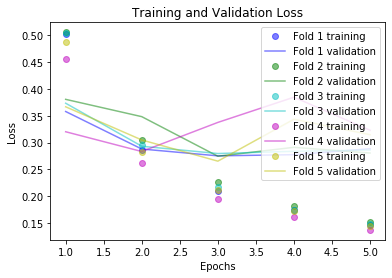

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, len(histories[0]["loss"])+1)

for idx, history_dict in histories.items():
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    color = ["b", "g", "c", "m", "y"][idx]
    # plot training loss in blue, dotted
    plt.plot(epochs, loss_values, "{}o".format(color), label="Fold {} training".format(idx+1), alpha=0.3)
    # plot validation loss in blue, solid
    plt.plot(epochs, val_loss_values, "{}".format(color), label="Fold {} validation".format(idx+1), alpha=0.3)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

Plotting training and validation accuracy.

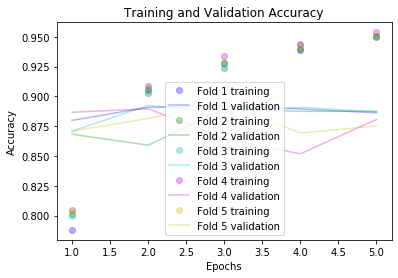

In [25]:
plt.clf()

for idx, history_dict in histories.items():
    acc_values = history_dict["binary_accuracy"]
    val_acc_values = history_dict["val_binary_accuracy"]
    color = ["b", "g", "c", "m", "y"][idx]
    # plot training loss in blue, dotted
    plt.plot(epochs, acc_values, "{}o".format(color), label="Fold {} training".format(idx+1), alpha=0.3)
    # plot validation loss in blue, solid
    plt.plot(epochs, val_acc_values, "{}".format(color), label="Fold {} validation".format(idx+1), alpha=0.3)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### Prediction of New Data

In [26]:
predictions = model.predict(x_test)
# print sample with prediction result
review_idx = np.random.randint(0, 25000-1)
review_pred = predictions[review_idx]
review_text = " ".join(reverse_word_index.get(i - 3, "?") for i in test_data[review_idx])

print("Review predicted " + str(review_pred[0]) + "% positive.")
print(review_text)

Review predicted 9.655952e-06% positive.
? this film ? miserably in the uk and it didn't deserve to the trailer of this film is slightly misleading and i guess it ? critics and audiences into thinking it was ? part 2 while the film was ? that way to ? on the earlier success of joe ? ? winning film it's very different in tone it focuses on an imagination of sorts of ? poet dylan ? life during the second world war as the writer of propaganda films for the war effort and his subsequent return to ? director john quickly introduces ? matthew ? childhood sweetheart vera phillips played by ? knightley she was ? first love in their ? but the moment has passed and singer vera only wants it as a beautiful memory or does she vera unexpectedly strikes up a close bond with the other woman in ? life queen of ireland love of my life mother of my child ? thomas ? miller the three form a sort of ? a ? in war struck london but vera then falls for a dashing soldier william cillian murphy they quickly mar